In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import itertools
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [2]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO4_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data.drop('reservoir_capacity', 1, inplace=True)




/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_30240/121917515.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('reservoir_capacity', 1, inplace=True)


In [3]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [4]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [5]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [6]:
warnings.filterwarnings("ignore")
val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    model=sm.tsa.statespace.SARIMAX(X_train[:,0], exog= X_train[:,1:],
                                      order=(2, 1, 2),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    results = model.fit(disp=False)
    
    # predict on test set
    preds = results.forecast(steps=len(X_val), exog=X_val[:,1:])

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))


365it [8:44:14, 86.18s/it] 


In [7]:
# Calculate and print mean RMSE over all predictions

print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Mean RMSE: 12754.681504516977
Mean MAPE: inf
Mean MAE: 10651.843344663881


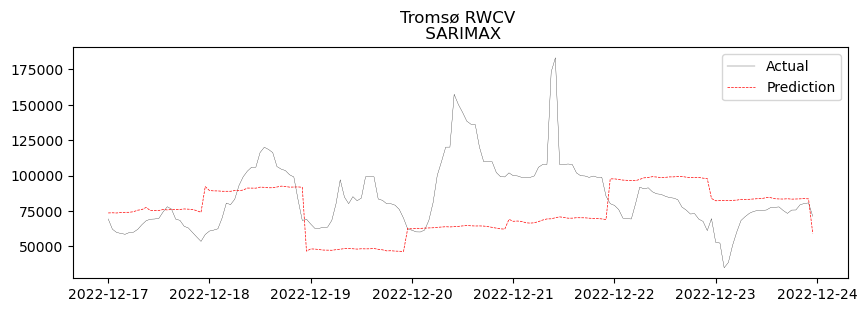

In [8]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)

train_set.index.freq = 'H'

shifted_index = train_set.index[-24*14:-24*7]

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(shifted_index.values, train_set['target'][(-24*14)+1:(-24*7)+1].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(shifted_index.values, forecast[(-24*14)+1:(-24*7)+1], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tromsø RWCV \n SARIMAX')
plt.legend()
plt.show()



In [9]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


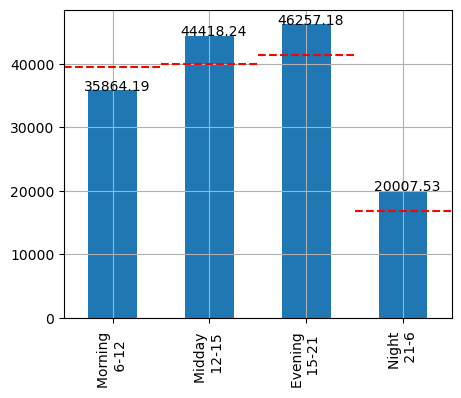

In [10]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=39456, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40010, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=41405, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=16851, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [11]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


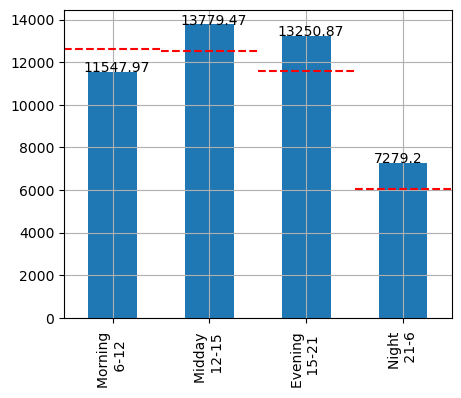

In [12]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=12597, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=12547, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=11571, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=6047, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

RMSE: 30875.6232, MAPE: 45.4659% , MAE:  22584.7679, RSS:  2014331573816.8987


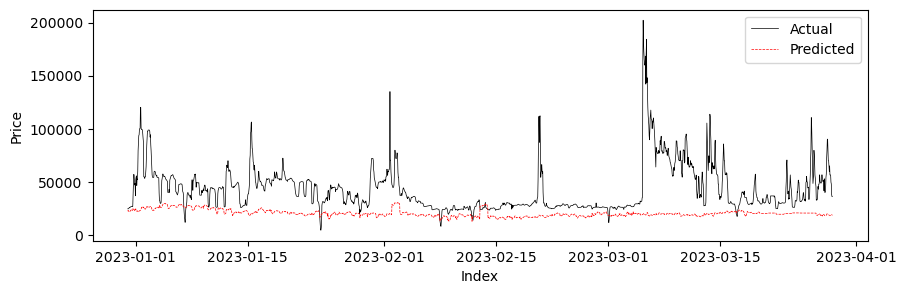

In [13]:
model = sm.tsa.statespace.SARIMAX(train_X[:,0], exog= train_X[:,1:], 
                                  order=(2, 1, 2),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)
preds = results.forecast(steps=len(test_X), exog=test_X[:,1:])


# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)
# Calculate and print errors

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()


In [14]:
# Calculate and print errors

# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)


Residual Sum of Squares (RSS):  1.8755815660220166e+17
